In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
%matplotlib inline

In [134]:
af = np.load("data/autoens_learning_data.npz")
print(af.keys())
hf = np.load("data/hetmem_learning_data.npz")
print(hf.keys())

['p_recall', 'p_keys', 'p_weights', 'p_error', 'p_values']
['p_recall', 'p_keys', 'p_weights', 'p_error', 'p_values']


In [135]:
qs = af["p_keys"]
ans = af["p_values"]
f_rec = af["p_recall"]
g_rec = hf["p_recall"]

In [136]:
f_err = af["p_error"]
g_err = hf["p_error"]
fail_w = af["p_weights"]
good_w = hf["p_weights"]
print(f_err.shape)
print(g_err.shape)
print(fail_w.shape)
print(good_w.shape)

(10800, 10)
(10800, 10)
(1080, 10, 2400)
(1080, 10, 2400)


In [137]:
f_res = np.sum(np.abs(f_err), axis=1)
g_res = np.sum(np.abs(g_err), axis=1)

(30, 300)
(8400,)


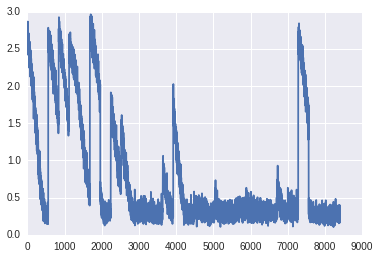

In [117]:
# Delete 5ms off of the onset of the question, since this is how long it takes
# for the answer to propigate to the network
per = int(0.3 / 0.001)
tmp_res = g_res[:9000].reshape((-1, per))
print(tmp_res.shape)
g_filt = np.delete(tmp_res, slice(0, 20), axis=1).flatten()
print(g_filt.shape)
plt.plot(g_filt)

In [139]:
def filt_outlier(dat, per=300, win=9000):
    tmp_res = dat[:win].reshape((-1, per))
    return np.delete(tmp_res, slice(0, 20), axis=1).flatten()

g_filt = filt_outlier(g_res)
f_filt = filt_outlier(f_res)

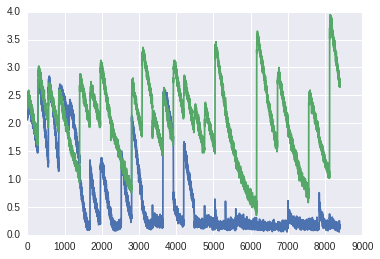

In [140]:
plt.plot(g_filt)
plt.plot(f_filt)

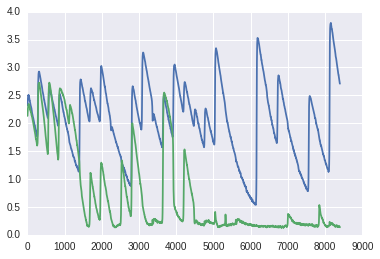

In [141]:
plt.plot(nengo.Lowpass(0.005).filtfilt(f_filt, dt=0.001))
plt.plot(nengo.Lowpass(0.005).filtfilt(g_filt, dt=0.001))

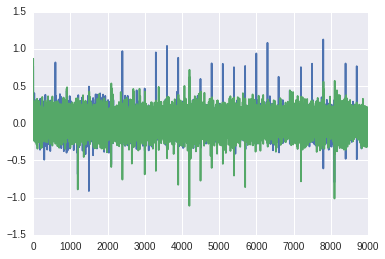

In [108]:
plt.plot(np.diff(g_res[:9000]))
plt.plot(np.diff(f_res[:9000]))

In [118]:
g_diff = np.diff(g_res[:9000])
print(g_diff.shape)
print(g_diff[g_diff > 0.6].shape)
print(np.arange(g_diff.size)[g_diff > 0.6])

f_diff = np.diff(f_res[:9000])
print(f_diff.shape)
print(f_diff[f_diff > 0.6].shape)
print(np.arange(f_diff.size)[f_diff > 0.6])

(8999,)
(18,)
[   1  599 2399 3299 3599 3900 4799 5099 5399 5699 6000 6300 6599 7199 7499
 7799 8399 8699]
(8999,)
(3,)
[   1 4203 4206]


In [13]:
# plot the weights that fluctuated the most
# highest frequency?
# largest total diff?
print(weights.shape)
print(weights[0, 0, 500:510])

(1080, 32, 1600)
[  0.00000000e+00   0.00000000e+00  -2.62433675e-10   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -2.62433675e-10  -2.62433675e-10
   0.00000000e+00  -2.91654404e-09]


In [14]:
d_w = np.diff(weights, axis=2)
print(d_w.shape)

(1080, 32, 1599)


In [19]:
d_res = np.sum(d_w, axis=2)
print(d_res.shape)
np.max(d_res, axis=0)

(1080, 32)


array([  7.62329653e-21,   1.05879118e-20,   2.51992302e-20,
         1.43995601e-20,   1.27054942e-20,   9.95263713e-21,
         1.01643954e-20,   6.03510975e-21,   7.57035697e-21,
         1.56701095e-20,   6.67038446e-21,   1.11702470e-20,
         1.46113183e-20,   1.45054392e-20,   1.22819777e-20,
         1.29172524e-20,   1.23878569e-20,   1.29172524e-20,
         1.04820327e-20,   1.71524172e-20,   1.21760986e-20,
         1.39760436e-20,   2.37169225e-20,   8.78796683e-21,
         7.83505476e-21,   1.33937085e-20,   2.91167576e-21,
         1.16467030e-20,   1.05879118e-20,   6.98802181e-21,
         6.22039821e-21,   1.82112084e-20])

(1080, 32)


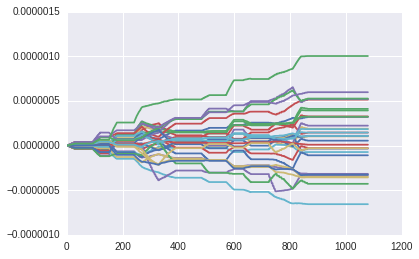

In [22]:
nrn = np.argmax(np.mean(np.var(weights, axis=0), axis=1))
pt_nrn = weights[..., nrn]
plt.plot(pt_nrn)
print(pt_nrn.shape)

In [24]:
nrn

15

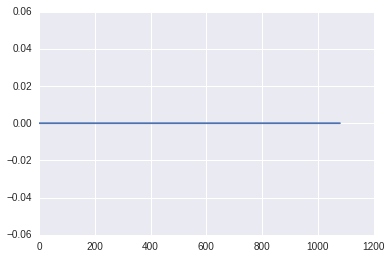

In [26]:
plt.plot(weights[:, 0, 0])

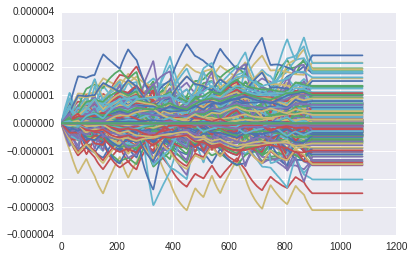

In [27]:
for ww in range(10):
    plt.plot(weights[:, :, ww])

(900, 32)


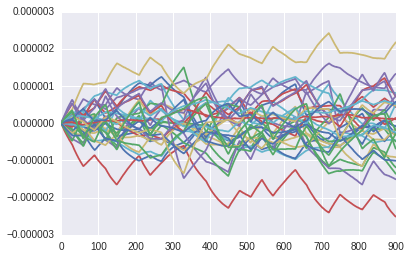

In [6]:
plt.plot(weights[:900, :, 3])
print(weights[:900, :, 3].shape)

In [9]:
tot_neurons = weights[:900, :, 3].shape[-1]
freqs = np.zeros(tot_neurons)
for n in range(tot_neurons):
    freqs[n] = np.sum(np.abs(np.fft.fft(weights[:900, n, 3])))
print("Max index: %s" % np.argmax(freqs))
print("Min index: %s" % np.argmin(freqs))

Max index: 2
Min index: 26


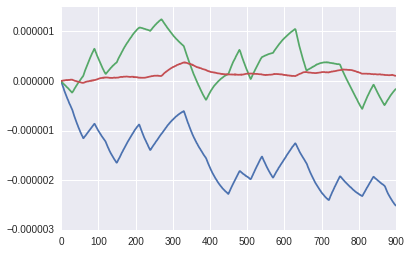

In [12]:
plt.plot(weights[:900, 2, 3])
plt.plot(weights[:900, 12, 3])
plt.plot(weights[:900, 26, 3])